In [1]:
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
from pandas.core.common import SettingWithCopyWarning

import warnings
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

import random
import datetime
import time
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, ConcatDataset
import torch.optim as optim


In [2]:
# Initialise the random state
num = random.randint(1, 500)

torch.manual_seed(num)
print(f"The generated random seed is {num}") #347

The generated random seed is 468


In [3]:
# Load the processed emg data
emg_path = "/Users/niharawarawita/Desktop/MSc Project/Data/EMG_data_collection/emg_combined_stats.csv"
emg_df = pd.read_csv(emg_path)
emg_df.head()

,new_id,id,p_id,itr_id,prj_id,ppt_id,rating,hand,clt_id,ch_01,ch_02,ch_03,ch_04,ch_05,ch_06,ch_07,ch_08,timestamp
0,1,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.006998,0.010902,0.016429,0.024816,0.034724,2022-02-13 11:24:11.302
1,2,132383,19,119,622,16,6,0,27,0.001062,0.011202,0.002932,0.001948,0.002860,0.000817,0.015065,0.004675,2022-02-13 11:24:11.302
2,3,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.004439,0.024374,2022-02-13 11:24:11.302
3,4,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.006901,0.001948,0.002860,0.014796,0.005313,0.044074,2022-02-13 11:24:11.302
4,5,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.005313,0.004675,2022-02-13 11:24:11.302


### Preprocess the emg data

In [4]:
emg_df.rename(columns={'p_id': 'participant_id', 'itr_id': 'interaction_id',  'prj_id': 'project_id',  'ppt_id': 'property_id', 'clt_id': 'clothes_id'}, inplace=True)
emg_df.head()

,new_id,id,participant_id,interaction_id,project_id,property_id,rating,hand,clothes_id,ch_01,ch_02,ch_03,ch_04,ch_05,ch_06,ch_07,ch_08,timestamp
0,1,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.006998,0.010902,0.016429,0.024816,0.034724,2022-02-13 11:24:11.302
1,2,132383,19,119,622,16,6,0,27,0.001062,0.011202,0.002932,0.001948,0.002860,0.000817,0.015065,0.004675,2022-02-13 11:24:11.302
2,3,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.004439,0.024374,2022-02-13 11:24:11.302
3,4,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.006901,0.001948,0.002860,0.014796,0.005313,0.044074,2022-02-13 11:24:11.302
4,5,132383,19,119,622,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.005313,0.004675,2022-02-13 11:24:11.302


In [5]:
emg_df.drop(['new_id', 'id', 'project_id'], axis=1, inplace=True)
emg_df.head()

,participant_id,interaction_id,property_id,rating,hand,clothes_id,ch_01,ch_02,ch_03,ch_04,ch_05,ch_06,ch_07,ch_08,timestamp
0,19,119,16,6,0,27,0.001062,0.003030,0.002932,0.006998,0.010902,0.016429,0.024816,0.034724,2022-02-13 11:24:11.302
1,19,119,16,6,0,27,0.001062,0.011202,0.002932,0.001948,0.002860,0.000817,0.015065,0.004675,2022-02-13 11:24:11.302
2,19,119,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.004439,0.024374,2022-02-13 11:24:11.302
3,19,119,16,6,0,27,0.001062,0.003030,0.006901,0.001948,0.002860,0.014796,0.005313,0.044074,2022-02-13 11:24:11.302
4,19,119,16,6,0,27,0.001062,0.003030,0.002932,0.001948,0.002860,0.014796,0.005313,0.004675,2022-02-13 11:24:11.302


In [6]:
# Convert the timestamp to the datetime format
emg_df['timestamp']= pd.to_datetime(emg_df['timestamp'])

In [7]:
# Sort the values in each df by ascending value of the timestamp
emg_df.sort_values(by=['timestamp'], inplace=True)

In [8]:
# Split the data into hands 0 (left) and 1 (right)
emg_0 = emg_df[emg_df.hand == 0]
emg_1 = emg_df[emg_df.hand == 1]

# Reset indexes
emg_0.reset_index(inplace=True, drop = True)
emg_1.reset_index(inplace=True, drop = True)


In [9]:
def interaction_time(df):
    # Create a column for the starting time of each interaction 
    df['interaction_start_time'] = df['timestamp'].groupby(df['interaction_id']).transform('min')
    # Create a column for the ending time of each interaction 
    df['interaction_end_time'] = df['timestamp'].groupby(df['interaction_id']).transform('max')
    
    df['interaction_duration'] = df['interaction_end_time'] - df['interaction_start_time']#.datetime.total_seconds()
    df['interaction_duration'] = df['interaction_duration'].dt.total_seconds()
    return df

emg_0 = interaction_time(emg_0)
emg_1 = interaction_time(emg_1)


In [10]:
def emg_get_15_seconds(interaction_id, emg_interaction_df, emg_df):
    interaction_end_time = emg_interaction_df.iloc[0,16]
    threshold = interaction_end_time - datetime.timedelta(0,16)

    # Remove rows with interaction_id with a timestamp less than the threshold from the dfs
    emg_df.drop(emg_df[(emg_df.interaction_id==interaction_id) & (emg_df.timestamp<=threshold)].index, inplace=True)
    
    # Drop the interaction_start_time and interaction_end_time for the dfs
    emg_df.drop(['interaction_start_time', 'interaction_end_time', 'interaction_duration'], axis=1, inplace=True)

    # Recalculate the columns
    emg_df = interaction_time(emg_df)
     
    return emg_df

emg_191_0 = emg_0[emg_0.interaction_id==191]
emg_0 = emg_get_15_seconds(191, emg_191_0, emg_0) 
emg_196_0 = emg_0[emg_0.interaction_id==196]
emg_0 = emg_get_15_seconds(196, emg_196_0, emg_0) 

emg_191_1 = emg_1[emg_1.interaction_id==191]
emg_1 = emg_get_15_seconds(191, emg_191_1, emg_1)  
emg_196_1 = emg_1[emg_1.interaction_id==196]
emg_1 = emg_get_15_seconds(196, emg_196_1, emg_1)  
emg_296_1 = emg_1[emg_1.interaction_id==296]
emg_1 = emg_get_15_seconds(296, emg_296_1, emg_1) 



In [11]:
def add_property_names_column(df):
    df.insert(3, 'property_name', 'smoothness')
    df.property_name[df['property_id'] == 13] = 'thickness'
    df.property_name[df['property_id'] == 14] = 'warmth'
    df.property_name[df['property_id'] == 15] = 'flexibility'
    df.property_name[df['property_id'] == 16] = 'softness'
    df.property_name[df['property_id'] == 17] = 'enjoyment'
    return df

emg_0 = add_property_names_column(emg_0)
emg_1 = add_property_names_column(emg_1)


In [12]:
emg_0 = emg_0[emg_0.property_name != 'enjoyment']
emg_1 = emg_1[emg_1.property_name != 'enjoyment']


In [13]:
def renumber_socks(df):
    df.clothes_id[(df['clothes_id'] == 25) | (df['clothes_id'] == 31) | (df['clothes_id'] == 38) | (df['clothes_id'] == 44) | (df['clothes_id'] == 50) | (df['clothes_id'] == 56)] = 1
    df.clothes_id[(df['clothes_id'] == 26) | (df['clothes_id'] == 32) | (df['clothes_id'] == 39) | (df['clothes_id'] == 45) | (df['clothes_id'] == 51) | (df['clothes_id'] == 57)] = 2
    df.clothes_id[(df['clothes_id'] == 27) | (df['clothes_id'] == 33) | (df['clothes_id'] == 40) | (df['clothes_id'] == 46) | (df['clothes_id'] == 52) | (df['clothes_id'] == 58)] = 3
    df.clothes_id[(df['clothes_id'] == 28) | (df['clothes_id'] == 34) | (df['clothes_id'] == 41) | (df['clothes_id'] == 47) | (df['clothes_id'] == 53) | (df['clothes_id'] == 59)] = 4
    df.clothes_id[(df['clothes_id'] == 29) | (df['clothes_id'] == 35) | (df['clothes_id'] == 42) | (df['clothes_id'] == 48) | (df['clothes_id'] == 54) | (df['clothes_id'] == 60)] = 5
    df.clothes_id[(df['clothes_id'] == 30) | (df['clothes_id'] == 36) | (df['clothes_id'] == 43) | (df['clothes_id'] == 49) | (df['clothes_id'] == 55) | (df['clothes_id'] == 61)] = 6
    return df

emg_0 = renumber_socks(emg_0)
emg_1 = renumber_socks(emg_1)


In [14]:
def combine_classes_rating(df):
    df.insert(5, 'rating_level', 'medium')
    df.loc[df['rating'] > 5,'rating_level'] = 'high'
    df.loc[df['rating'] < 3,'rating_level'] = 'low'
    return df
    
emg_0 = combine_classes_rating(emg_0)
emg_1 = combine_classes_rating(emg_1)


In [15]:
def represent_rating_level_numerically(df):
    df.insert(6, 'rating_level_num', 1)
    df.loc[df['rating_level'] == 'medium','rating_level_num'] = 2
    df.loc[df['rating_level'] == 'high','rating_level_num'] = 3
    return df

emg_0 = represent_rating_level_numerically(emg_0)
emg_1 = represent_rating_level_numerically(emg_1)


In [16]:
def create_subwindows(df, num_subwindows=15):
    
    # Create a column with the subwindow numbers
    df.insert(9, 'sub_window_num', num_subwindows)
    for num in range(num_subwindows-1,0,-1):
        df.sub_window_num[pd.to_datetime(df['timestamp']) <= pd.to_datetime(df['interaction_start_time']) + datetime.timedelta(0,num)] = num
        
    return df

emg_0 = create_subwindows(emg_0, num_subwindows=15)
emg_1 = create_subwindows(emg_1, num_subwindows=15)



In [17]:
def downsample_emg(df):
    column_names = ['ch_01','ch_02','ch_03','ch_04','ch_05','ch_06','ch_07','ch_08']
    for col in column_names:
        new_col_name = 'mean_'+col           
        df[new_col_name] = df[col].groupby([df['interaction_id'], df['sub_window_num']]).transform('mean')
    return df


emg_0 = downsample_emg(emg_0)
emg_1 = downsample_emg(emg_1)



In [18]:
emg_0_new = emg_0[['participant_id','clothes_id', 'property_id','property_name','interaction_id','hand','rating','rating_level','rating_level_num', 'sub_window_num', 'mean_ch_01','mean_ch_02','mean_ch_03','mean_ch_04','mean_ch_05','mean_ch_06','mean_ch_07','mean_ch_08']]
emg_1_new = emg_1[['participant_id','clothes_id', 'property_id','property_name','interaction_id','hand','rating','rating_level','rating_level_num', 'sub_window_num', 'mean_ch_01','mean_ch_02','mean_ch_03','mean_ch_04','mean_ch_05','mean_ch_06','mean_ch_07','mean_ch_08']]


In [19]:
print(emg_0_new.shape)
print(emg_0_new.shape)

(1307504, 18)
(1307504, 18)


In [20]:
# Remove duplicates
emg_0_new.drop_duplicates(keep='first', inplace=True)
emg_1_new.drop_duplicates(keep='first', inplace=True)

# Reset the indexes
emg_0_new.reset_index(drop=True, inplace=True) 
emg_1_new.reset_index(drop=True, inplace=True) 


In [21]:
print(emg_0_new.shape)
print(emg_0_new.shape)

(2694, 18)
(2694, 18)


max: 15
min: 9
mean: 15.0
std: 0.4


<AxesSubplot:xlabel='interaction_id'>

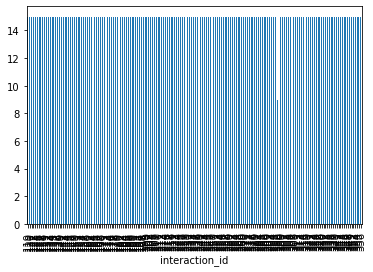

In [22]:
df0 = emg_0_new.groupby('interaction_id')['sub_window_num'].nunique()
print(f'max: {df0.max()}')
print(f'min: {df0.min()}')
print(f'mean: {round(df0.mean(),1)}')
print(f'std: {round(df0.std(),1)}')
df0.plot.bar()

max: 15
min: 9
mean: 15.0
std: 0.5


<AxesSubplot:xlabel='interaction_id'>

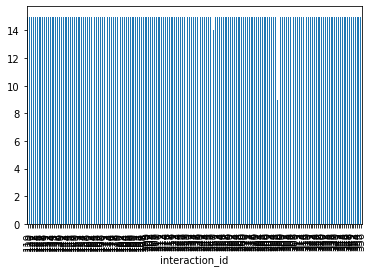

In [23]:
df1 = emg_1_new.groupby('interaction_id')['sub_window_num'].nunique()
print(f'max: {df1.max()}')
print(f'min: {df1.min()}')
print(f'mean: {round(df1.mean(),1)}')
print(f'std: {round(df1.std(),1)}')
df1.plot.bar()

### Create X and y data

In [24]:
def create_X(df):
    dim1 = df.interaction_id.nunique()
    #num_timestamps_per_interaction = df.groupby('interaction_id')['sub_window_num'].nunique()
    dim2 = df.sub_window_num.nunique()
        
    X = np.zeros((dim1, dim2, 8)) 

    itr_id_lst = df.interaction_id.unique().tolist()

    for i in range(len(itr_id_lst)):
        itr_id = itr_id_lst[i]
        itr_id_df = df[df.interaction_id==itr_id]       
        
        for j in range(itr_id_df.shape[0]):
            starting_index = 10
            vals_arr = itr_id_df.iloc[j,starting_index:].values
            X[i,j] = vals_arr
    
    X_tensor = torch.Tensor(X)    
    return X_tensor


In [25]:
def create_y(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['participant_id', 'clothes_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    y_test = df2[predicting_feature].values
    y_test = y_test - 12
    
    y_test = torch.Tensor(y_test)    
    y_test = y_test.type(torch.LongTensor)
    
    return y_test


### Create the model

In [26]:
input1 = torch.rand(180,15,8)
input2 = torch.rand(180,15,6*2)
conv1 = nn.Conv1d(in_channels=15, out_channels=15, kernel_size=3, stride=1, padding=0, groups=15) # Change kernel size to 3
pool = nn.MaxPool1d(1, 1) # Change kernel size to 1 and stride to 1
rnn = nn.LSTM(6, 3, 1, batch_first=True)
h0 = torch.randn(1, 15, 6)
c0 = torch.randn(1, 15, 6)
fc1 = nn.Linear(15 * 6 * 2, 20)
fc2 = nn.Linear(20, 5)

print(input1.shape)
x=conv1(input1)
print(x.shape)

x=pool(x)
print(x.shape)

x, (hn,cn) = rnn(x)
print(x.shape)
print('=================')
y = torch.flatten(input2, 1)
print(y.shape)
y = fc1(y)
print(y.shape)
y = fc2(y)
print(y.shape)

torch.Size([180, 15, 8])
torch.Size([180, 15, 6])
torch.Size([180, 15, 6])
torch.Size([180, 15, 3])
torch.Size([180, 180])
torch.Size([180, 20])
torch.Size([180, 5])


In [27]:
0.001,0.01,0.1

(0.001, 0.01, 0.1)

In [28]:
def create_y_train(df, predicting_feature = 'property_id'):
    # Create a dataset with only the required columns
    df2 = df[['participant_id', 'clothes_id', 'property_id', 'rating_level_num']]

    # Remove duplicates
    df2.drop_duplicates(keep='first', inplace=True)

    # Reset the indexes
    df2.reset_index(drop=True, inplace=True) 
    
    ## Create y train
    # CreatE an instance of a one-hot-encoder
    encoder = OneHotEncoder(handle_unknown='ignore')

    # Perform one-hot encoding on the specified column 
    encoder_df = pd.DataFrame(encoder.fit_transform(df2[[predicting_feature]]).toarray())
    
    # Convert to a numpy array
    y_train = encoder_df.to_numpy()
    
    # Convert to a tensor
    y_train = torch.Tensor(y_train)
  
    return y_train


In [55]:
class CNN_LSTM(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.conv1 = nn.Conv1d(in_channels=15, out_channels=15, kernel_size=3, stride=1, padding=0, groups=15) # Change kernel size to 3
        self.pool = nn.MaxPool1d(1, 1) # Change kernel size to 1 and stride to 1
        self.rnn = nn.LSTM(6, 3, 1, batch_first=True)
        #self.h0 = torch.randn(1, 50, 7)
        #self.c0 = torch.randn(1, 50, 7)
        #self.fc1 = nn.Linear(15 * 3 * 2, 20)
        self.fc1 = nn.Linear(15 * 3 * 2, 5)
        
           
    def forward(self, x1, x2):
        x1 = self.pool(F.relu(self.conv1(x1))) # Use tanh instead?
        x2 = self.pool(F.relu(self.conv1(x2))) # Use tanh instead?
        
        #x = self.pool(F.relu(self.conv2(x)))
        x1, (hn, cn) = self.rnn(x1) #, (self.h0, self.c0)
        #x1 = F.tanh(x1)
        x2, (hm, cm) = self.rnn(x2) # (self.h0, self.c0)
        #x2 = F.tanh(x2)
        
        x = torch.cat((x1, x2), 2)
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        #x = F.relu(self.fc1(x))
        x = F.softmax(self.fc1(x), dim=1)
        return x
    

In [56]:
m = CNN_LSTM()
print(m)

CNN_LSTM(
  (conv1): Conv1d(15, 15, kernel_size=(3,), stride=(1,), groups=15)
  (pool): MaxPool1d(kernel_size=1, stride=1, padding=0, dilation=1, ceil_mode=False)
  (rnn): LSTM(6, 3, batch_first=True)
  (fc1): Linear(in_features=90, out_features=5, bias=True)
)


def plot_loss(num_epochs, loss_vals):
    plt.plot(np.linspace(1, num_epochs, num_epochs).astype(int), loss_vals)
    plt.show

In [87]:
def find_best_model_for_fold(train_dataloader, val_dataloader, num_epochs, learning_rate):

    # Model
    train_model = CNN_LSTM()

    # Loss and Optimiser
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = optim.SGD(train_model.parameters(), lr=learning_rate, momentum=0.7)

    best_avg_loss = np.inf
    best_model = None
    best_model_epoch_num = np.inf
    #avg_loss_lst = []

    for epoch in range(num_epochs):  # loop over the dataset multiple times

        #Set the model in training mode
        train_model.train()

        # Initialise the total training and validation loss
        total_train_loss = 0
        total_val_loss = 0
        avg_loss = 0
        count = 0

        #running_loss = 0.0
        for i, train_data in enumerate(train_dataloader, 0):
            count += 1
            # get the inputs; data is a list of [input1, input2, label]
            train_input1, train_input2, train_labels = train_data

            #train_labels = train_labels.type(torch.LongTensor)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            train_preds = train_model(train_input1, train_input2)
            #print(train_labels)#

            train_loss = criterion(train_preds, train_labels)
            train_loss.backward()
            optimizer.step()

            # Update training loss
            total_train_loss += train_loss.item()

        # Switch off auto grad for evaluation
        with torch.no_grad():

            # Set the model in evaluation mode
            train_model.eval()

            for j, val_data in enumerate(val_dataloader, 0):
            # get the inputs; data is a list of [input1, input2, label]
                val_input1, val_input2, val_labels = val_data

                #val_labels = val_labels.type(torch.LongTensor)

                val_preds = train_model(val_input1, val_input2)

                # Update validation loss
                val_loss = criterion(val_preds, val_labels)

                total_val_loss += val_loss.item()
                
        avg_training_loss = total_train_loss / count

        avg_loss = (avg_training_loss + total_val_loss) / 2
        
        
        #if epoch % 5 == 0:    # print every 2000 mini-batches
        print(f'epoch {epoch+1}: training loss = {round(avg_training_loss,4)}, validation loss = {round(total_val_loss,4)}, average loss = {round(avg_loss,4)}')
            # print('[%d, %5d] loss: %.3f' %
            #    (epoch + 1, i + 1, running_loss / 2000))
           # running_loss = 0.0
        #avg_loss_lst.append(avg_loss)
        
        #print(f'epoch {epoch+1}: train loss = {round(total_train_loss,2)}, val loss = {round(total_val_loss,2)}, average loss = {round(avg_loss,2)}')

        if avg_loss < best_avg_loss:
            best_model_epoch_num = epoch
            best_avg_loss = avg_loss
            best_model = train_model.state_dict()
            #best_model_params = list(model.parameters())

    #print(f'The model with the lowest average loss ({round(best_avg_loss,2)}) occured in epoch {best_model_epoch_num+1}')

    return best_avg_loss, best_model #, avg_loss_lst, 


In [88]:
def create_combined_lst(lr_lst, num_epochs_lst):
    lst = []
    for ele1 in lr_lst:
        for ele2 in num_epochs_lst:
            lst.append((ele1,ele2))
    return lst   

In [89]:
t1 = time.time()

In [90]:
def NN_LOS0CV(data_0, data_1, num_folds=5, predicting_feature='property_id', num_epoch_lst=[5,10,20], learning_rate_lst=[0.001,0.01,0.1], random_state=num): #, num_inner_folds=5

    # Set fixed random number seed
    torch.manual_seed(num)
    
    for cloth_id in range(1,7): 
        print(f'LEAVING SOCK {cloth_id} OUT:')
        # Split the data into training and testing
        training_data_0 = data_0[data_0.clothes_id != cloth_id] 
        training_data_1 = data_1[data_1.clothes_id != cloth_id] 
        testing_data_0 = data_0[data_0.clothes_id == cloth_id] 
        testing_data_1 = data_1[data_1.clothes_id == cloth_id] 

        # Data preparation
        X_train_0 = create_X(training_data_0)
        X_train_1 = create_X(training_data_1)        
        y_train = create_y(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X(testing_data_0) 
        X_test_1 = create_X(testing_data_1)
        y_test = create_y(testing_data_0, predicting_feature = 'property_id')
        
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test) 
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, num_workers=2, batch_size=30)
        
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
        
        # Create a combined lst
        combo_lst = create_combined_lst(num_epoch_lst, learning_rate_lst)
        
        min_avg_loss_subject = np.inf
        best_model_subject = None
        best_params_subject = None

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            print(f'FOLD {fold+1}:')
            
            min_avg_loss_fold = np.inf
            best_model_fold = None
            best_params_fold = None
            avg_loss_dict = {}
            
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler)
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler)
            

            for combo in combo_lst:
                print(f'lr={combo[1]}, num epochs={combo[0]}:')
                min_avg_loss_combo, best_model_combo = find_best_model_for_fold(train_dataloader, val_dataloader, combo[0], combo[1])
                print('-------------------')
                #if combo[0] not in avg_loss_dict.keys():
                #    avg_loss_dict[combo[0]] = [avg_loss_lst]
                #else:
                 #   avg_loss_dict[combo[0]].append(avg_loss_lst)
                 
                if min_avg_loss_combo < min_avg_loss_fold:
                    min_avg_loss_fold = min_avg_loss_combo
                    best_model_fold = best_model_combo
                    best_params_fold = combo
                    
            if min_avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = min_avg_loss_fold
                best_model_subject = best_model_fold
                best_params_subject = best_params_fold
                
            print(f'The best model for fold {fold+1} has an average loss of {round(min_avg_loss_fold,1)} and has parameters: learning rate = {best_params_fold[1]}, num_epochs = {best_params_fold[0]}')
                
           # for key in avg_loss_dict.keys():                             
            #    fig = plt.figure(f"Sock {cloth_id}, fold {fold+1}, num_epochs = {key}")
            #    for lst_num in range(len(avg_loss_dict[key])):                    
            #        plt.plot(np.linspace(1, key, key).astype(int), avg_loss_dict[key][lst_num])
             #   plt.title(f"Training loss for Sock {cloth_id}, fold {fold+1}, num_epochs = {key}")
              #  plt.legend(['lr=0.001', 'lr=0.01', 'lr=0.1'])
            
            #print(f'The best model for fold {fold+1} has an average loss of {round(min_avg_loss_fold,1)} and has parameters: learning rate = {best_params_fold[0]}, num_epochs = {best_params_fold[1]}')
        print(f'The model with the least average loss ({round(min_avg_loss_subject,1)}) has parameters: learning rate = {best_params_subject[0]}, num_epochs = {best_params_subject[1]}')
        
        # save trained model - this is the last model saved 
        name = 'model_sock_'+str(cloth_id)+'.pt'
        torch.save(best_model_subject, name)
        
        test_model = CNN_LSTM()
        test_model.load_state_dict(torch.load(name))
        
        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next()
    
        test_preds = test_model(test_input1, test_input2)
        _, test_predicted = torch.max(test_preds, 1)
        
        test_predicted_np = test_predicted.numpy()
        test_labels_np = test_labels.numpy()        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving sock {cloth_id} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        print('--------------------------------')
  
        


In [102]:
def NN_LOS0CV1(data_0, data_1, num_folds=5, predicting_feature='property_id', num_epoch_lst=[5,10,20], learning_rate_lst=[0.001,0.01,0.1], random_state=num): #, num_inner_folds=5

    # Set fixed random number seed
    torch.manual_seed(num)
    
    for cloth_id in range(1,7): 
        print(f'LEAVING SOCK {cloth_id} OUT:')
        # Split the data into training and testing
        training_data_0 = data_0[data_0.clothes_id != cloth_id] 
        training_data_1 = data_1[data_1.clothes_id != cloth_id] 
        testing_data_0 = data_0[data_0.clothes_id == cloth_id] 
        testing_data_1 = data_1[data_1.clothes_id == cloth_id] 

        # Data preparation
        X_train_0 = create_X(training_data_0)
        X_train_1 = create_X(training_data_1)        
        y_train = create_y_train(training_data_0, predicting_feature = 'property_id')
        X_test_0 = create_X(testing_data_0) 
        X_test_1 = create_X(testing_data_1)
        y_test = create_y(testing_data_0, predicting_feature = 'property_id')
        
 
        # Create the datasets and dataloaders
        train_dataset = TensorDataset(X_train_0, X_train_1, y_train) 
        
        test_dataset = TensorDataset(X_test_0, X_test_1, y_test) 
        test_dataloader = torch.utils.data.DataLoader(test_dataset, shuffle=True, num_workers=2, batch_size=30)
        
            
        # Configure the cross-validation procedure
        cv_inner = KFold(n_splits=num_folds, shuffle=True, random_state=num)
        
        # Create a combined lst
        combo_lst = create_combined_lst(num_epoch_lst, learning_rate_lst)
        
        min_avg_loss_subject = np.inf
        best_model_subject = None
        best_params_subject = None

        for fold, (train_ids, val_ids) in enumerate(cv_inner.split(train_dataset)):
            print(f'FOLD {fold+1}:')
            #print()
            print(train_ids)
            print(val_ids)
            
            min_avg_loss_fold = np.inf
            best_model_fold = None
            best_params_fold = None
            avg_loss_dict = {}
            
            # Sample elements randomly from a given list of ids, no replacement.
            train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids) # The ids are the same for both
            val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

            # Define data loaders for training and testing data in this fold
            train_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=train_subsampler, batch_size=10)
            val_dataloader = torch.utils.data.DataLoader(train_dataset, sampler=val_subsampler, batch_size=50)
            

            for combo in combo_lst:
                print(f'lr={combo[1]}, num epochs={combo[0]}:')
                min_avg_loss_combo, best_model_combo = find_best_model_for_fold(train_dataloader, val_dataloader, combo[0], combo[1])
                print('-------------------')
                #if combo[0] not in avg_loss_dict.keys():
                #    avg_loss_dict[combo[0]] = [avg_loss_lst]
                #else:
                 #   avg_loss_dict[combo[0]].append(avg_loss_lst)
                 
                if min_avg_loss_combo < min_avg_loss_fold:
                    min_avg_loss_fold = min_avg_loss_combo
                    best_model_fold = best_model_combo
                    best_params_fold = combo
                    
            if min_avg_loss_fold < min_avg_loss_subject:
                min_avg_loss_subject = min_avg_loss_fold
                best_model_subject = best_model_fold
                best_params_subject = best_params_fold
                
            print(f'The best model for fold {fold+1} has an average loss of {round(min_avg_loss_fold,1)} and has parameters: learning rate = {best_params_fold[1]}, num_epochs = {best_params_fold[0]}')
                
           # for key in avg_loss_dict.keys():                             
            #    fig = plt.figure(f"Sock {cloth_id}, fold {fold+1}, num_epochs = {key}")
            #    for lst_num in range(len(avg_loss_dict[key])):                    
            #        plt.plot(np.linspace(1, key, key).astype(int), avg_loss_dict[key][lst_num])
             #   plt.title(f"Training loss for Sock {cloth_id}, fold {fold+1}, num_epochs = {key}")
              #  plt.legend(['lr=0.001', 'lr=0.01', 'lr=0.1'])
            
            #print(f'The best model for fold {fold+1} has an average loss of {round(min_avg_loss_fold,1)} and has parameters: learning rate = {best_params_fold[0]}, num_epochs = {best_params_fold[1]}')
        print(f'The model with the least average loss ({round(min_avg_loss_subject,1)}) has parameters: learning rate = {best_params_subject[0]}, num_epochs = {best_params_subject[1]}')
        
        # save trained model - this is the last model saved 
        name = 'model_sock_'+str(cloth_id)+'.pt'
        torch.save(best_model_subject, name)
        
        test_model = CNN_LSTM()
        test_model.load_state_dict(torch.load(name))
        
        dataiter = iter(test_dataloader) 
        test_input1, test_input2, test_labels = dataiter.next()
    
        test_preds = test_model(test_input1, test_input2)
        
        test_preds_np = test_preds.detach().numpy()
        test_predicted_np = np.argmax(test_preds_np, axis = 1)
        #_, test_predicted = torch.max(test_preds, 1)
        
        #test_predicted_np = test_predicted.numpy()
        test_labels_np = test_labels.numpy()        

        conf_mat = confusion_matrix(test_labels_np, test_predicted_np, labels=[0, 1, 2, 3, 4])
        macro_f1_score = f1_score(test_labels_np, test_predicted_np, average='macro') 
        micro_f1_score = f1_score(test_labels_np, test_predicted_np, average='micro')  
        acc = accuracy_score(test_labels_np, test_predicted_np)

        print(f"Leaving sock {cloth_id} out")
        print("(1) Confusion matrix:\n", conf_mat)
        print(f"(2) micro F1 score = {round(micro_f1_score,2)}")
        print(f"(3) macro F1 score = {round(macro_f1_score,2)}")    
        print(f"(4) Percentage Classification accuracy = {round(acc*100,2)}%")
        
        print('--------------------------------')
  
        



In [103]:
df = emg_0_new[['interaction_id', 'clothes_id','property_name']]
df = df[df.clothes_id!=1]
df.drop_duplicates(keep='first', inplace=True)
#emg_1_new.drop_duplicates(keep='first', inplace=True)


lst = df.property_name.to_list()
lst[17]

'softness'

In [104]:
lst_2 = [ 11,  17,  31,  37,  47,  48,  50,  52,  63,  66,  68,  69,  74,  84,  92,  97,  98, 100, 104, 113, 121, 122, 126, 129, 133, 134, 135, 141, 143, 149]
for i in range(len(lst_2)):
    print(f'{lst_2[i]}, {lst[i]}')

11, softness
17, flexibility
31, smoothness
37, thickness
47, warmth
48, smoothness
50, thickness
52, flexibility
63, softness
66, warmth
68, warmth
69, smoothness
74, softness
84, flexibility
92, thickness
97, warmth
98, thickness
100, softness
104, smoothness
113, flexibility
121, softness
122, thickness
126, flexibility
129, smoothness
133, warmth
134, warmth
135, softness
141, thickness
143, smoothness
149, flexibility


In [105]:
emg_0_new.head()

,participant_id,clothes_id,property_id,property_name,interaction_id,hand,rating,rating_level,rating_level_num,sub_window_num,mean_ch_01,mean_ch_02,mean_ch_03,mean_ch_04,mean_ch_05,mean_ch_06,mean_ch_07,mean_ch_08
0,19,3,16,softness,119,0,6,high,3,1,0.012167,0.008337,0.007780,0.006640,0.009395,0.023830,0.015122,0.020056
1,19,3,16,softness,119,0,6,high,3,2,0.019790,0.017228,0.008390,0.006409,0.007686,0.014378,0.016086,0.019061
2,19,3,16,softness,119,0,6,high,3,3,0.012231,0.009103,0.007627,0.006512,0.009618,0.021827,0.016003,0.017120
3,19,3,16,softness,119,0,6,high,3,4,0.009712,0.005384,0.005342,0.004616,0.007886,0.020806,0.014199,0.014924
4,19,3,16,softness,119,0,6,high,3,5,0.014063,0.011389,0.007741,0.006422,0.007504,0.011997,0.014111,0.018028


In [106]:
NN_LOS0CV1(emg_0_new, emg_1_new, num_folds=3, predicting_feature='property_id', learning_rate_lst=[0.05], num_epoch_lst=[1], random_state=num)
#0.001,0.01,0.1

LEAVING SOCK 1 OUT:
FOLD 1:
[  0   1   2   3   4   5   6   7   9  10  12  13  14  15  16  18  19  20
  22  23  24  26  27  29  30  32  33  34  35  36  39  41  42  44  45  46
  49  51  53  54  55  56  57  58  60  61  62  64  65  67  70  71  72  73
  75  77  78  79  80  82  83  86  87  88  89  91  95  96  99 101 102 103
 105 106 107 109 110 112 114 115 118 119 120 123 124 125 127 128 130 131
 132 136 138 139 140 142 145 146 147 148]
[  8  11  17  21  25  28  31  37  38  40  43  47  48  50  52  59  63  66
  68  69  74  76  81  84  85  90  92  93  94  97  98 100 104 108 111 113
 116 117 121 122 126 129 133 134 135 137 141 143 144 149]
lr=0.05, num epochs=1:
epoch 1: training loss = 1.6112, validation loss = 1.6076, average loss = 1.6094
-------------------
The best model for fold 1 has an average loss of 1.6 and has parameters: learning rate = 0.05, num_epochs = 1
FOLD 2:
[  0   1   2   3   5   8   9  11  15  17  18  19  20  21  23  24  25  27
  28  31  36  37  38  39  40  43  47  48  50  

In [ ]:
#%matplotlib inline
NN_LOS0CV(emg_0_new, emg_1_new, num_folds=3, predicting_feature='property_id', learning_rate_lst=[0.001,0.01,0.1], num_epoch_lst=[5,10,20], random_state=num)


In [ ]:
t2=time.time()

In [ ]:
t2-t1